# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Skillfactory---Практический-Machine-Learning" data-toc-modified-id="Skillfactory---Практический-Machine-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Skillfactory - Практический Machine Learning</a></div><div class="lev2 toc-item"><a href="#19/02/2018---Аномалии,-работа-с-признаками,-пайплайны-(практика)" data-toc-modified-id="19/02/2018---Аномалии,-работа-с-признаками,-пайплайны-(практика)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>19/02/2018 - Аномалии, работа с признаками, пайплайны (практика)</a></div><div class="lev1 toc-item"><a href="#Создание-пайплайна-и-генерация-признаков" data-toc-modified-id="Создание-пайплайна-и-генерация-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание пайплайна и генерация признаков</a></div><div class="lev2 toc-item"><a href="#Посмотрим-на-данные" data-toc-modified-id="Посмотрим-на-данные-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Посмотрим на данные</a></div><div class="lev2 toc-item"><a href="#Генерим-признаки" data-toc-modified-id="Генерим-признаки-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Генерим признаки</a></div><div class="lev2 toc-item"><a href="#Подбор-гипер-параметров" data-toc-modified-id="Подбор-гипер-параметров-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подбор гипер-параметров</a></div><div class="lev3 toc-item"><a href="#Pipeline" data-toc-modified-id="Pipeline-231"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Pipeline</a></div><div class="lev3 toc-item"><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-232"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Подбор гиперпараметров</a></div><div class="lev4 toc-item"><a href="#Grid-search" data-toc-modified-id="Grid-search-2321"><span class="toc-item-num">2.3.2.1&nbsp;&nbsp;</span>Grid search</a></div><div class="lev4 toc-item"><a href="#Random-Search" data-toc-modified-id="Random-Search-2322"><span class="toc-item-num">2.3.2.2&nbsp;&nbsp;</span>Random Search</a></div><div class="lev3 toc-item"><a href="#HyperOpt" data-toc-modified-id="HyperOpt-233"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>HyperOpt</a></div><div class="lev2 toc-item"><a href="#Ваш-черед" data-toc-modified-id="Ваш-черед-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Ваш черед</a></div><div class="lev3 toc-item"><a href="#Новые-признаки" data-toc-modified-id="Новые-признаки-241"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Новые признаки</a></div><div class="lev2 toc-item"><a href="#Поиск-гиперпараметров" data-toc-modified-id="Поиск-гиперпараметров-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Поиск гиперпараметров</a></div>

# Skillfactory - Практический Machine Learning
## 19/02/2018 - Аномалии, работа с признаками, пайплайны (практика)

<center> Шестаков Андрей </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import Timestamp, DateOffset
import re 
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, rand

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import lognorm as sp_lognorm
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, rand
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, MinMaxScaler

from sklearn.model_selection import cross_val_score
from tqdm import tqdm_notebook

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Создание пайплайна и генерация признаков
<center>Шестаков Андрей</center>

В этом задании мы рассмотрим данные с предыдущего Sberbank Data Science Contest. К сожалению найти страницу с конкурсом уже не получается.

Одной из задач была опредление пола владельца карты по его транзакциям на карте. Зачем это нужно - одному сберу известно, но эта задача была хороша тем, что в ней можно нагенерировать много разных признаков

Есть такая [презентация](https://alexanderdyakonov.files.wordpress.com/2016/10/dj2016_sdsj_vis.pdf) с предварительным анализом данных и идеями про признаки

Нам понадобятся файлы `customers_gender_train.csv`, `transactions.tsv.gz`, `mcc_types.tsv` и `trans_types.tsv`.

## Посмотрим на данные

Это метки ответов

In [2]:
df_gender = pd.read_csv('data/customers_gender_train.csv')
df_gender.head()

,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


Это сами транзакции (отрицательные транзакции - списывание, положительные - зачисление на счет)

In [3]:
%%time
df_transactions = pd.read_csv('data/transactions.csv.gz')
df_transactions.head()

CPU times: user 12.4 s, sys: 1.3 s, total: 13.7 s
Wall time: 14.6 s


Далее, расшифровки кодов [mcc](https://ru.wikipedia.org/wiki/Merchant_Category_Code) и транзакций

In [4]:
df_tr = pd.read_csv('data/tr_types.csv', sep=';')
df_tr.head()

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [5]:
df_mcc = pd.read_csv('data/tr_mcc_codes.csv', sep=';')
df_mcc.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


Первое что мы видем - это странная дата и суммы в транзакциях. 

В принципе, посмотрев на исходное распределение "относительных" дат по какой-нибудь гендерной группы mcc, становится примерно понятно, что за даты закодированы.

Ну а суммы транзакций организаторы просто умножили на $\pi^{\exp}$ =)

Преобразование будет проделано ниже, но при желании, можете сами со всем разобраться.

In [6]:
def preproc_transactions(df_transactions):
    sec_per_day = 86400
    sec_per_hour = 3600
    
    start_date = 1420070400 - 154 * sec_per_day - 3 * sec_per_hour
    
    df_transactions.loc[:, 'day'] = df_transactions.tr_datetime\
                                               .str.split(' ')\
                                               .str.get(0)\
                                               .astype(int)
    df_transactions.loc[:, 'time_raw'] = df_transactions.tr_datetime\
                                                    .str.split(' ')\
                                                    .str.get(1)

    # set temp dt
    df_transactions.loc[:, 'dt_temp'] = pd.to_datetime(df_transactions.loc[:, 'time_raw'], 
                                                    format='%H:%M:%S')\
                                        + DateOffset(years=115)
    
    df_transactions = df_transactions.assign(dt = lambda x: x.dt_temp.astype(np.int64) // 10**9
                                             + (x.day - 153) * sec_per_day)\
                                     .assign(weekday = lambda x: ((x.day + 4) % 7 + 1))
        
    df_transactions.loc[:, 'datetime'] = pd.to_datetime(df_transactions.dt, unit='s')
    df_transactions.loc[:, 'date'] = df_transactions.loc[:, 'datetime'].dt.strftime('%Y-%m-%d')
    df_transactions.loc[:, 'hour'] = df_transactions.loc[:, 'datetime'].dt.strftime('%H')
    
    df_transactions = df_transactions.drop(['dt_temp', 'time_raw', 'tr_datetime'], axis=1)
    
    df_transactions.loc[:, 'amount'] = np.round(df_transactions.loc[:, 'amount']/(np.pi**np.exp(1)))
            
    return df_transactions

In [7]:
%%time
df_transactions = df_transactions.pipe(preproc_transactions)

CPU times: user 2min 5s, sys: 10.1 s, total: 2min 16s
Wall time: 2min 12s


In [8]:
df_transactions.head()

,customer_id,mcc_code,tr_type,amount,term_id,day,dt,weekday,datetime,date,hour
0,39026145,4814,1030,-100.0,NaN,0,1406888606,5,2014-08-01 10:23:26,2014-08-01,10
1,39026145,6011,7010,2500.0,NaN,1,1406974769,6,2014-08-02 10:19:29,2014-08-02,10
2,39026145,4829,2330,-2500.0,NaN,1,1406974856,6,2014-08-02 10:20:56,2014-08-02,10
3,39026145,5499,1010,-62.0,NaN,1,1406975994,6,2014-08-02 10:39:54,2014-08-02,10
4,39026145,5499,1010,-41.0,NaN,2,1407080022,7,2014-08-03 15:33:42,2014-08-03,15


## Генерим признаки

В качестве базовых признаков, можно взять, например, 
* количество (доля) транзакций по каждому mcc_code
* количество (доля) транзакций в разные промежутки времени

In [9]:
def gen_features(df_gender, df_transactions):
    
    df_mcc_counts = \
        df_transactions.pivot_table(index=['customer_id'], columns='mcc_code', values='amount', 
                             aggfunc=np.size, fill_value=0)

    df_mcc_counts = df_mcc_counts.rename_axis(lambda x: 'mcc_{}_count'.format(x), axis=1)

    df_hour_rations = \
        df_transactions.pivot_table(index=['customer_id'], columns='hour', values='amount', 
                             aggfunc=np.size, fill_value=0)

    # Сложная и нетривиальная конструкция
    total = df_hour_rations.sum(axis=1)
    df_hour_rations.loc[:, 'morning'] = (df_hour_rations.loc[:, '05':'11'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'day'] = (df_hour_rations.loc[:, '12':'17'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'evening'] = (df_hour_rations.loc[:, '18':'23'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'night'] = (df_hour_rations.loc[:, '00':'04'].sum(axis=1).T/total).T


    # Объединяем:
    df_features = df_gender.join(df_mcc_counts, on='customer_id', how='left')\
                           .join(df_hour_rations.loc[:, ['morning', 'day', 'evening', 'night']], on='customer_id', how='left')
        
    return df_features

In [10]:
df_features = df_gender.pipe(gen_features, df_transactions)

In [11]:
label = 'gender'
idx_features = df_features.columns != label

In [12]:
X = df_features.loc[:, idx_features].values
y = df_features.loc[:, ~idx_features].values.flatten()

## Подбор гипер-параметров

### Pipeline

Сделаем простой sklearn пайплайн, который делает следующее:
* Нормирует признаки через StandartScaler
* Запускает лог-регрессию

In [13]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [14]:
RND_SEED = 123

### Подбор гиперпараметров

До этого мы исключительно смотрели, как влияет на меру качества какой-то один параметр при фиксированных остальных. Пришло время перебирать все что можно!

В базовом варианте, это делается либо через `Grid Search`, либо через `Random Search`. Какие ключевые отличия?
* В `Grid Search` вы в явнов виде задаете возможные значения каждого гипер-параметра, который хотите варьировать. Соответственно, выполняется **полный** перебор всех возможных комбинаций
* В `Random Search` допукается указание распределения параметров, например "равномерно, на интервале от 0 до 100" или "нормальное распределение с таким-то цетром и такой-то дисперсией. Соответственно, так как это случайный перебор, то **вы** просто **задаете** количество случайных комбинаций, которые будут проверяться

Может показаться, что делать случайный перебор опасно - там же все случайно. Но на практике именно он и искользуется в силу двух причин
* Полный перебор большого количества комбинаций очень долгий
* Мы можем просто пропустить значения гиперпараметра, которые сильно влияют на метрику качества (см рисунок снизу)

<img src='img/gridsearch.jpeg'>

Попробуем оба варианта

#### Grid search

In [15]:
# Задаем значения параметров, которые хотим проверить

# в данном случае "__" разленяет название гиперпараметра от этапа, где этот гиперпараметр используется
# если у нас будет не пайплайн, а просто один классификатор, то разделитель указывать не нужно
param_grid = {
    'scaler__with_mean': [False, True],
    'clf__penalty': ['l1', 'l2'],
    'clf__random_state': [RND_SEED],
    'clf__C': np.logspace(-5, 3, 10)
}

print(param_grid)

# Задаем схему кросс-валидации
cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

{'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': array([  1.00000000e-05,   7.74263683e-05,   5.99484250e-04,
         4.64158883e-03,   3.59381366e-02,   2.78255940e-01,
         2.15443469e+00,   1.66810054e+01,   1.29154967e+02,
         1.00000000e+03])}


In [16]:
grid_searcher = GridSearchCV(model, param_grid, 
                             scoring='roc_auc', 
                             n_jobs=-1, cv=cv, 
                             verbose=2)

grid_searcher.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV]  clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV]  clf__C=1e-05, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__C=1e-05, clf__penalty=l1, clf

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s


[CV]  clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV]  clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV] clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   0.5s
[CV]  clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   0.5s
[CV] clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV] clf__C=0.000599484250319, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=7.74263682681e-05, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   0.5s
[CV]  clf__C=0.000599484250319, clf__penalty=l1, clf__random_state=

[CV]  clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False, total=   0.5s
[CV] clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False, total=   0.5s
[CV] clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   1.0s
[CV] clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   1.0s
[CV] clf__C=0.035938136638, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.00464158883361, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__C=0.035938136638, clf__penalty=l1, clf__random_state=123, scaler__wi

[CV]  clf__C=0.278255940221, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   1.5s
[CV] clf__C=0.278255940221, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.278255940221, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   1.5s
[CV] clf__C=0.278255940221, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.278255940221, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   1.6s
[CV] clf__C=2.15443469003, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=2.15443469003, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.9s
[CV] clf__C=2.15443469003, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.278255940221, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   7.2s
[CV] clf__C=2.15443469003, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.4s


[CV]  clf__C=16.681005372, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   2.9s
[CV] clf__C=16.681005372, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=16.681005372, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   2.5s
[CV] clf__C=129.154966501, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=16.681005372, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   2.8s
[CV] clf__C=129.154966501, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=16.681005372, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   2.7s
[CV]  clf__C=129.154966501, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__C=129.154966501, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=129.154966501, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=12

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': array([  1.00000e-05,   7.74264e-05,   5.99484e-04,   4.64159e-03,
         3.59381e-02,   2.78256e-01,   2.15443e+00,   1.66810e+01,
         1.29155e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

На выходе в grid_searcher можно посмотреть, какая комбинация оказалась наилучшей, сколько занял рачет и напрямую достать лучшую модель.

In [17]:
grid_searcher.best_params_

{'clf__C': 0.035938136638046257,
 'clf__penalty': 'l1',
 'clf__random_state': 123,
 'scaler__with_mean': True}

In [18]:
grid_searcher.best_score_

0.83336427641533994

In [19]:
results = pd.DataFrame(grid_searcher.cv_results_)

In [20]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_clf__random_state,param_scaler__with_mean,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.337450,0.025809,0.041105,0.008665,1e-05,l1,123,False,"{'clf__C': 1e-05, 'clf__penalty': 'l1', 'clf__...",0.500000,...,0.500000,0.000000,36,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.429396,0.026977,0.013209,0.005775,1e-05,l1,123,True,"{'clf__C': 1e-05, 'clf__penalty': 'l1', 'clf__...",0.500000,...,0.500000,0.000000,36,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
2,0.306051,0.018838,0.025212,0.018006,1e-05,l2,123,False,"{'clf__C': 1e-05, 'clf__penalty': 'l2', 'clf__...",0.785334,...,0.793321,0.006108,34,0.797821,0.800335,0.800359,0.796988,0.800062,0.799113,0.001423
3,0.560725,0.050569,0.029246,0.016947,1e-05,l2,123,True,"{'clf__C': 1e-05, 'clf__penalty': 'l2', 'clf__...",0.786911,...,0.797828,0.010103,33,0.799328,0.810066,0.808778,0.799038,0.803717,0.804185,0.004604
4,0.234154,0.024457,0.018707,0.011696,7.74264e-05,l1,123,False,"{'clf__C': 7.74263682681e-05, 'clf__penalty': ...",0.500000,...,0.500000,0.000000,36,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [21]:
best_model = grid_searcher.best_estimator_

#### Random Search

In [22]:
sp_lognorm(4).rvs()

24.344703564769713

In [23]:
# Задаем значения параметров, которые хотим проверить
# Теперь с распределениями
param_grid = {
    'scaler__with_mean': [False, True],
    'clf__penalty': ['l1', 'l2'],
    'clf__random_state': [RND_SEED],
    'clf__C': sp_lognorm(4)
}

print(param_grid)

{'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1ac787bf28>}


In [24]:
# Рассмотрим 20 случайных комбинаций
random_searcher = RandomizedSearchCV(model, param_grid, n_iter=20, 
                                     random_state=RND_SEED,
                                     scoring='roc_auc', 
                                     n_jobs=-1, cv=cv, 
                                     verbose=2)

random_searcher.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV] clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__C=54.0214822195, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.0130036861306, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__C=54.0214822195, clf__penalty=l1, clf__r

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s


[CV]  clf__C=0.0661689071764, clf__penalty=l1, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__C=0.684657972423, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.684657972423, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.8s
[CV]  clf__C=0.684657972423, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.7s
[CV] clf__C=0.684657972423, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV] clf__C=0.684657972423, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.179846689606, clf__penalty=l2, clf__random_state=123, scaler__with_mean=True, total=   2.2s
[CV] clf__C=0.169326269146, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.684657972423, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.8s
[CV] clf__C=0.169326269146, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False 
[

[CV] clf__C=0.00329706433825, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=37.6533069054, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.8s
[CV] clf__C=0.00329706433825, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__C=0.00329706433825, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.4s
[CV] clf__C=0.359702678393, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.00329706433825, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.4s
[CV] clf__C=0.359702678393, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.00329706433825, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total=   0.5s
[CV] clf__C=0.359702678393, clf__penalty=l2, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__C=0.00329706433825, clf__penalty=l1, clf__random_state=123, scaler__with_mean=True, total

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1ac787bf28>},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

Аналогичный выхлоп

In [25]:
random_searcher.best_params_

{'clf__C': 0.066168907176401004,
 'clf__penalty': 'l1',
 'clf__random_state': 123,
 'scaler__with_mean': False}

In [26]:
random_searcher.best_score_

0.83315837075874744

In [27]:
results = pd.DataFrame(random_searcher.cv_results_)

In [28]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_clf__random_state,param_scaler__with_mean,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.337638,0.031878,0.029012,0.010001,0.0130037,l1,123,False,"{'clf__C': 0.0130036861306, 'clf__penalty': 'l...",0.827471,...,0.829823,0.004285,10,0.835125,0.834699,0.835108,0.835925,0.833296,0.83483,0.000864
1,0.763639,0.028199,0.018994,0.008993,54.0215,l1,123,True,"{'clf__C': 54.0214822195, 'clf__penalty': 'l1'...",0.829480,...,0.829797,0.003311,14,0.849482,0.850480,0.849284,0.850177,0.848428,0.84957,0.000720
2,2.614380,0.377043,0.015490,0.007889,0.0988254,l1,123,True,"{'clf__C': 0.0988253618904, 'clf__penalty': 'l...",0.831304,...,0.832555,0.003359,3,0.848460,0.849136,0.847942,0.849445,0.847168,0.84843,0.000820
3,0.724918,0.121748,0.015420,0.006479,739.331,l1,123,True,"{'clf__C': 739.331314325, 'clf__penalty': 'l1'...",0.829471,...,0.829789,0.003311,15,0.849480,0.850481,0.849283,0.850175,0.848430,0.84957,0.000719
4,0.274952,0.040222,0.025464,0.013064,6.08732e-05,l1,123,False,"{'clf__C': 6.08732348326e-05, 'clf__penalty': ...",0.500000,...,0.500000,0.000000,19,0.500000,0.500000,0.500000,0.500000,0.500000,0.50000,0.000000


In [29]:
best_model = random_searcher.best_estimator_

### HyperOpt

Есть еще другой вариант - "умный" перебор параметров. И вот тут нам помогает библиотека `hyperopt`.

Если невдаваться в детали, то `hyperopt` определяет следующего набора-кандидата с помощью некоторого алгоритма, который балансирует исследование еще не изведанных областей значений гиперпараметров и направления, вдоль которых наблюдались улучшения целеой метрики.

То есть мы задаем некоторую функцию, и ставим себе цель **минимизировать** (такова договоренность в `hyperopt`) ее значение исходя из параметров, которые она принимает.

Например, возьмем функцию $f(x) = \sin(x)/x$ и будем искать ее минимум при условии, что $x$ будет равномерно распределен на интервале $[-7.5, 7.5]$

In [30]:
# sudo pip install networkx==1.11

In [31]:
trials = Trials()
best = fmin(
    fn=lambda x: -np.sin(x)/x,
    space=hp.uniform('x', -7.5, 7.5),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)


{'x': 0.044202740623018134}


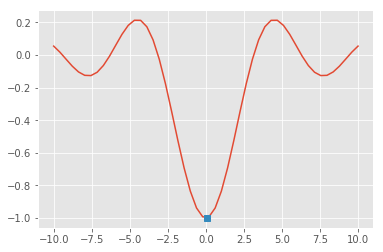

In [32]:
x = np.linspace(-10,10,50)
func = lambda x: -np.sin(x)/x
y = func(x)
plt.plot(x,y)

y_best = func(best['x'])
plt.plot(best['x'], y_best, marker='s')

Нашли)

Возвращаясь к нашим баранам, функция вданном случае будет возвращать метрику качества модели (пайплайна) на кроссвалидации. С помощью `hyperopt` мы будем искать минимум этой функции при заданных диаполознах значений гипер параметров.

Но самым важным плюсом, как по мне, является гибкость - в функцию, которую мы хотим минимизировать можно написать все что угодно. Например, сейчас я добавлю вариативность в пайплайне по типу шкалирования между - StandartScaler или RobustScaler.

In [33]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score

In [34]:
X = df_features.loc[:, idx_features].values
y = df_features.loc[:, ~idx_features].values.flatten()

In [35]:
def run_trials_template(X, y, params, evals=100):

    def hyperopt_cv(X, y, params):
        
        X_ = X.copy()
        
        # Отделяем параметры лог регрессии в отдельный словарь
        lm_params = {}
        for k, v in params.items():
            if k.startswith('glob'):
                continue                
            elif k.startswith('lm'):
                lm_params[k.split('_', 1)[1]] = v
        
        # Задаем шкалирование
        if params['scaler_type'] == 'standart':
            scaler = StandardScaler(with_mean=params['scaler_centering'])
        else:
            assert params['scaler_type'] == 'robust'
            scaler = RobustScaler(with_centering=params['scaler_centering'])
        
        # Создаем лог рег с нужными параметрами
        clf = LogisticRegression(**lm_params)
        
        # Итоговый пайплайн
        model = Pipeline([
            ('scaler', scaler),
            ('clf', clf)
        ])

        # Схема кросс-валидации
        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, 
                             random_state=RND_SEED)
        scores = cross_val_score(model, X_, y,
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=-1)

        # Возвращаем среднее значение метрики и отклонение (на всякий случай)
        return scores.mean(), scores.std()

    def f(params):
        acc, std = hyperopt_cv(X, y, params)
        return {'loss': -acc, 'qscore': -acc, 'qscore_std': std, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, 
                params, 
                algo=tpe.suggest, 
                max_evals=evals, 
                trials=trials, 
                verbose=1)
    
    return trials

In [36]:
# Задаем пространство поиска
space4_lm = {
    'lm_penalty': hp.choice('penalty', ['l1', 'l2']),
    'lm_C': hp.loguniform('C', -5, 3),
    'lm_class_weight': hp.choice('class_weight', [None, 'balanced']),
    'lm_random_state': RND_SEED,
    'scaler_type': hp.choice('scaler_type', ['standart', 'robust']),
    'scaler_centering': hp.choice('scaler_centering', [False, True])
}

In [37]:
# Запускаем поиск
trials = run_trials_template(X, y, space4_lm, evals=40)


In [38]:
def trials_df(trials):
    '''
    Функция форматирует результаты hyperopt в dataframe
    '''
    tr_dict = []
    for t in trials:
        trial = dict()
        for k, v in t['misc']['vals'].items():
            trial[k] = v[0]

        trial['qscore'] = -t['result']['qscore']
        trial['qscore_std'] = -t['result']['qscore_std']
        tr_dict.append(trial)

    df_res = pd.DataFrame.from_dict(tr_dict)
    df_res = df_res.sort_values('qscore', ascending=False)
    
    return df_res

Достаем результаты.

Стоит оговорится, что в некоторых столбцах указаны не фактические значение гиперпараметров, а их позиция в соответствуюем поле в `space4_lm`

In [39]:
df_trials = trials_df(trials)

Здесь `qscore` - метрика качесва, а `scaler_type = 1` означает, что был выбран `scaler_type = robust`

In [40]:
df_trials.head()

,C,class_weight,penalty,qscore,qscore_std,scaler_centering,scaler_type
34,0.028714,0,0,0.836903,-0.003461,0,1
28,0.019514,0,0,0.836728,-0.003823,1,1
23,0.028446,1,0,0.836711,-0.003540,1,1
24,0.023111,1,0,0.836704,-0.003778,1,1
26,0.020783,1,0,0.836668,-0.003916,1,1


## Ваш черед

### Новые признаки

Задание творческое - придумайте по новому признаку (группе признаков)
* На основе mcc (tr_type)
* На основе временного фактора
* На основе текстов из описания mcc

Реалиуйте их в функции, аналогичной `gen_features`.

In [41]:
ma = pymorphy2.MorphAnalyzer()
parse_results = {}
def get_parse_result(word):
    word = word.lower()
    if not (word in parse_results):
        pv = ma.parse(word)
        for p in pv:
            if p.tag.POS in ['ADJF', 'NOUN', 'VERB']:
                parse_results[word] = p.normal_form
                break

    if not (word in parse_results):
        parse_results[word] = None

    return parse_results[word]
# получаем слова
def getMeaningfullWords(text):
    meaning_words = []
    clean_text = re.sub('—.*', '', text)
    all_words = re.findall('[А-ЯЁа-яёA-Za-z]{3,}', clean_text)

    for word in all_words:
        parse_result = get_parse_result(word)
        if parse_result is not None:
            meaning_words.append(parse_result)

    return meaning_words
def df_to_cv(df_mcc):
    df = df_mcc.copy()    
    count_vect = TfidfVectorizer(tokenizer=getMeaningfullWords, smooth_idf=True, sublinear_tf=True,  min_df=0.009, max_df=0.91, norm='l1') 
# max_features=150)
    matrix_tfidf = count_vect.fit_transform(df['mcc_description']).toarray()    
    df = df.join(pd.DataFrame(matrix_tfidf, columns=count_vect.get_feature_names()), how='left')
    df = df.drop('mcc_description', axis=1)
    return df 

In [42]:
def take_features(df_transactions, df_mcc): 
    
    df_tns = df_transactions.copy()
    df_m = df_mcc.copy()
    
    df_mcc_counts = df_tns.pivot_table(index=['customer_id'], 
                                     columns='mcc_code', 
                                     values='amount', 
                                     aggfunc=np.size, 
                                     fill_value=0
                                    )
    df_mcc_counts = df_mcc_counts.rename_axis(lambda x: 'mcc_{}_count'.format(x), axis=1)

    df_hour_rations = df_tns.pivot_table(index=['customer_id'], 
                                                  columns='hour', 
                                                  values='amount',
                                                  aggfunc=np.size, 
                                                  fill_value=0
                                                 )
    total = df_hour_rations.sum(axis=1)
    df_hour_rations.loc[:, 'morning'] = (df_hour_rations.loc[:, '05':'11'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'day'] = (df_hour_rations.loc[:, '12':'17'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'evening'] = (df_hour_rations.loc[:, '18':'23'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'night'] = (df_hour_rations.loc[:, '00':'04'].sum(axis=1).T/total).T

#   Заджойним время суток и гендер    
    df_hour = df_gender.join(df_hour_rations.loc[:, ['morning', 'day', 'evening', 'night']], on='customer_id', how='left')
    
#   векторизируем описания mcc
    df_m_desc = df_to_cv(df_m)
        
#   объединяем транзакции и матрицу частот mcc-описаний кодов
    df_trs_mcc_desc = pd.merge(df_tns, df_m_desc, on='mcc_code', how='left')

#   группируем по кастомерам
    df_grouped = df_trs_mcc_desc.groupby('customer_id').sum().drop(['mcc_code','amount','day','dt','weekday', 'tr_type'], 
                                                                   axis=1)
    
#   объединяем данные по времени транзакций с остальной информацией
    df_features = df_hour.join(df_grouped, on='customer_id', how='left')\
                         .join(df_mcc_counts,'customer_id', how='left')

    df_features = df_features.drop(['customer_id'], axis=1)

    return df_features

In [43]:
%%time
df_features = df_transactions.pipe(take_features, df_mcc)

CPU times: user 28.7 s, sys: 37.8 s, total: 1min 6s
Wall time: 1min 5s


In [44]:
df_features.head()

,gender,morning,day,evening,night,авиакомпания,авиалиния,автомобиль,агентство,аксессуар,...,mcc_8299_count,mcc_8398_count,mcc_8641_count,mcc_8699_count,mcc_8999_count,mcc_9211_count,mcc_9222_count,mcc_9311_count,mcc_9399_count,mcc_9402_count
0,0,0.262658,0.329114,0.325949,0.082278,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0.352697,0.413555,0.042877,0.190871,0.0,0.0,0.0,0.473757,7.291712,...,0,0,0,0,1,0,0,0,2,0
2,1,0.296804,0.493151,0.196347,0.013699,0.0,0.0,0.0,0.000000,3.000000,...,0,0,0,0,2,0,0,0,0,0
3,1,0.247423,0.494845,0.216495,0.041237,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0,0.636943,0.239915,0.004246,0.118896,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df_features.shape

(12000, 267)

In [46]:
X = df_features.drop(['gender'], axis=1)
y = df_features['gender']

## Поиск гиперпараметров

Реализуйте функцию для hyperopt по перебору гипер параметров вашего пайплайна

На всякий случай почитайте еще про [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) и [пример](http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py)

In [47]:
# А это трансформер, который выбирает подможнество столбцов из матрицы X
# Который нужен для того, чтобы делать какие-то действия только для подмноества столбцов, 
# а потом объединять результаты
# Через FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):    
    def __init__(self, is_text):
        self.is_text = is_text
        
    def fit(self, X, y=None):        
        return self  
    
    def transform(self, X):
        if self.is_text:
            return X.filter(regex='[а-яА-Я]*')
        else:
            return X.filter(regex='[^а-яА-Я]')


In [52]:
def run_trials_template(X, y, params, evals=100):

    def hyperopt_cv(X, y, params):
        
        X_ = X.copy()
        
        # Отделяем параметры лог регрессии в отдельный словарь
        lm_params = {}
        for k, v in params.items():
            if k.startswith('glob'):
                continue                
            elif k.startswith('lm'):
                lm_params[k.split('_', 1)[1]] = v
        
        # Задаем шкалирование
        if params['scaler_type'] == 'standart':
            scaler = StandardScaler(with_mean=params['scaler_centering'])
        elif params['scaler_type'] == 'robust':
            scaler = RobustScaler(with_centering=params['scaler_centering'])
        elif params['scaler_type'] == 'max_abs':
            scaler = MaxAbsScaler()
        else:
            scaler = MinMaxScaler()
        
        # Создаем лог рег с нужными параметрами
        clf = LogisticRegression(**lm_params)
        
        # Текстовый пайплайн
        text_pipeline = Pipeline([
            ('selector', ColumnSelector(True))
        ])
        
        # Не текстовый пайплайн        
        not_text_pipeline = Pipeline([
            ('selector', ColumnSelector(False)),
            ('scaler', scaler)
        ])
        
        # Итоговый пайплайн        
        model = Pipeline([
            ('features', FeatureUnion([
                ('t', text_pipeline),
                ('ntp', not_text_pipeline)

            ])),
            ('clf', clf)
        ])

        # Схема кросс-валидации
        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits,
                             shuffle=True, 
                             random_state=RND_SEED)
        
        scores = cross_val_score(model, X_, y,
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=-1)

        # Возвращаем среднее значение метрики и отклонение (на всякий случай)
        return scores.mean(), scores.std()

    def f(params):
        acc, std = hyperopt_cv(X, y, params)
        return {'loss': -acc, 'qscore': -acc, 'qscore_std': std, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, 
                params, 
                algo=tpe.suggest, 
                max_evals=evals, 
                trials=trials
#                 verbose=1
               )
    
    return trials

In [53]:
# Задаем пространство поиска
space4_lm = {
    'lm_penalty': hp.choice('penalty', ['l1', 'l2']),
    'lm_C': hp.loguniform('C', -5, 3),
    'lm_class_weight': hp.choice('class_weight', [None, 'balanced']),
    'lm_random_state': RND_SEED,
    'scaler_type': hp.choice('scaler_type', ['standart', 'robust', 'max_abs', 'min_max']),
    'scaler_centering': hp.choice('scaler_centering', [False, True])
}

In [54]:
# Запускаем поиск
# %%time
trials = run_trials_template(X, y, space4_lm, evals=40)

In [55]:
def trials_df(trials):
    '''
    Функция форматирует результаты hyperopt в dataframe
    '''
    tr_dict = []
    for t in trials:
        trial = dict()
        for k, v in t['misc']['vals'].items():
            trial[k] = v[0]

        trial['qscore'] = -t['result']['qscore']
        trial['qscore_std'] = -t['result']['qscore_std']
        tr_dict.append(trial)

    df_res = pd.DataFrame.from_dict(tr_dict)
    df_res = df_res.sort_values('qscore', ascending=False)
    
    return df_res

In [56]:
df_trials = trials_df(trials)

In [57]:
df_trials = trials_df(trials)
df_trials.head()

,C,class_weight,penalty,qscore,qscore_std,scaler_centering,scaler_type
38,0.039569,0,0,0.838786,-0.003781,1,2
31,0.044489,0,0,0.838774,-0.003589,1,2
22,0.028697,0,0,0.838651,-0.003958,1,2
24,0.051650,0,0,0.838552,-0.003471,1,2
23,0.024283,0,0,0.838410,-0.004154,1,2


In [58]:
# благодаря добавлению описаний данные удалось обогадить
# MaxAbsScaler() и MinMaxScaler() показали лучшие результаты

In [59]:
# попробуем проделать работу с текстами и сделать перебор параметров для TfidfVectorizer:

In [60]:
def take_features_version_02(df_transactions, df_mcc): 
    
    df_tns = df_transactions.copy()
    df_m = df_mcc.copy()

    df_mcc_counts = df_tns.pivot_table(index=['customer_id'], 
                                       columns='mcc_code', 
                                       values='amount', 
                                       aggfunc=np.size,
                                       fill_value=0
                                      )
    df_mcc_counts = df_mcc_counts.rename_axis(lambda x: 'mcc_{}_count'.format(x), axis=1)

    df_hour_rations = df_tns.pivot_table(index=['customer_id'], 
                                                  columns='hour', 
                                                  values='amount',
                                                  aggfunc=np.size, 
                                                  fill_value=0
                                                 )
    total = df_hour_rations.sum(axis=1)
    df_hour_rations.loc[:, 'morning'] = (df_hour_rations.loc[:, '05':'11'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'day'] = (df_hour_rations.loc[:, '12':'17'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'evening'] = (df_hour_rations.loc[:, '18':'23'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'night'] = (df_hour_rations.loc[:, '00':'04'].sum(axis=1).T/total).T

#   Заджойним время суток и гендер
    df_hour = df_gender.join(df_hour_rations.loc[:, ['morning', 'day', 'evening', 'night']], on='customer_id', how='left')

#   Объединяем транзакции и описания mcc-кодов
    df_trs_mcc = pd.merge(df_tns, df_m, on='mcc_code', how='left')
    
#   Сгруппируем по кастомерам    
    df_trs_mcc_desc = df_trs_mcc.groupby('customer_id')['mcc_description'].apply(lambda x: ' '.join(x))
    
#   объединяем данные по времени транзакций с остальной информацией   
    df_features = df_hour.join(df_trs_mcc_desc, on='customer_id', how='left')\
                         .join(df_mcc_counts,'customer_id', how='left')

    df_features = df_features.drop(['customer_id'], axis=1)

    return df_features

In [61]:
%%time
df_features = df_transactions.pipe(take_features_version_02, df_mcc)

CPU times: user 15.3 s, sys: 5.23 s, total: 20.6 s
Wall time: 19.1 s


In [62]:
df_features.head()

,gender,morning,day,evening,night,mcc_description,mcc_742_count,mcc_1711_count,mcc_1731_count,mcc_1799_count,...,mcc_8299_count,mcc_8398_count,mcc_8641_count,mcc_8699_count,mcc_8999_count,mcc_9211_count,mcc_9222_count,mcc_9311_count,mcc_9399_count,mcc_9402_count
0,0,0.262658,0.329114,0.325949,0.082278,Финансовые институты — снятие наличности автом...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.352697,0.413555,0.042877,0.190871,Дилеры по продаже печатной продукции Места общ...,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
2,1,0.296804,0.493151,0.196347,0.013699,"Горючее топливо — уголь, нефть, разжиженный бе...",0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,1,0.247423,0.494845,0.216495,0.041237,Финансовые институты — снятие наличности автом...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.636943,0.239915,0.004246,0.118896,Финансовые институты — снятие наличности автом...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df_features.shape

(12000, 190)

In [64]:
X = df_features.drop(['gender'], axis=1)
y = df_features['gender']

In [74]:
class ColumnSelector_02(BaseEstimator, TransformerMixin):    
    def __init__(self, is_text):
        self.is_text = is_text
        
    def fit(self, X, y=None):        
        return self  
    
    def transform(self, X):
        if self.is_text:
            return X['mcc_description']
        else:
            return X.loc[:, X.columns != 'mcc_description']

In [79]:
def run_trials_template_02(X, y, params, evals=100):

    def hyperopt_cv_02(X, y, params):
        
        X_ = X.copy()
        
        # Отделяем параметры лог регрессии в отдельный словарь
        lm_params = {}
        tfdf_params = {}
        for k, v in params.items():
            if k.startswith('glob'):
                continue                
            elif k.startswith('lm'):
                lm_params[k.split('_', 1)[1]] = v
            elif k.startswith('tfdf'):
                tfdf_params[k.split('_', 1)[1]] = v
        
        # Задаем шкалирование
        if params['scaler_type'] == 'standart':
            scaler = StandardScaler(with_mean=params['scaler_centering'])
        elif params['scaler_type'] == 'robust':
            scaler = RobustScaler(with_centering=params['scaler_centering'])
        elif params['scaler_type'] == 'max_abs':
            scaler = MaxAbsScaler()
        else:
            scaler = MinMaxScaler()
        
        # Создаем лог рег с нужными параметрами
        clf = LogisticRegression(**lm_params)
        tfdf = TfidfVectorizer(tokenizer=getMeaningfullWords, min_df=0.009, max_df=0.91, 
                               **tfdf_params)
        
        
        # Текстовый пайплайн
        text_pipeline = Pipeline([
            ('selector', ColumnSelector_02(True)),
            ('tfdf', tfdf)
        ])
        
        # Не текстовый пайплайн        
        not_text_pipeline = Pipeline([
            ('selector', ColumnSelector_02(False)),
            ('scaler', scaler)
        ])
        
        # Итоговый пайплайн        
        model = Pipeline([
            ('features', FeatureUnion([
                ('t', text_pipeline),
                ('ntp', not_text_pipeline)

            ])),
            ('clf', clf)
        ])

        # Схема кросс-валидации
        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits,
                             shuffle=True, 
                             random_state=RND_SEED)
        
        scores = cross_val_score(model, X_, y,
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=-1)

        # Возвращаем среднее значение метрики и отклонение (на всякий случай)
        return scores.mean(), scores.std()

    def f(params):
        acc, std = hyperopt_cv_02(X, y, params)
        return {'loss': -acc, 'qscore': -acc, 'qscore_std': std, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, 
                params, 
                algo=tpe.suggest, 
                max_evals=evals, 
                trials=trials 
#                 verbose=1
               )
    
    return trials

In [80]:
# Задаем пространство поиска
space4_lm_02 = {
    'lm_penalty': hp.choice('penalty', ['l1', 'l2']),
    'lm_C': hp.loguniform('C', -5, 3),
    'lm_class_weight': hp.choice('class_weight', [None, 'balanced']),
    'lm_random_state': RND_SEED,
    'scaler_type': hp.choice('scaler_type', ['standart', 'robust', 'max_abs', 'min_max']),
    'scaler_centering': hp.choice('scaler_centering', [False, True]),
    'tfdf_ngram_range': hp.choice('ngram_range', [(1,1), (1,2)]),
    'tfdf_norm': hp.choice('norm', ['l1', 'l2']),
    'tfdf_use_idf': hp.choice('use_idf', [True, False]),
    'tfdf_smooth_idf': hp.choice('smooth_idf', [True, False]),
    'tfdf_sublinear_tf': hp.choice('sublinear_tf', [True, False])
}

In [81]:
# Запускаем поиск
# %%time
trials_02 = run_trials_template_02(X, y, space4_lm_02, evals=40)

In [82]:
df_trials = trials_df(trials_02)
df_trials.head()

,C,class_weight,ngram_range,norm,penalty,qscore,qscore_std,scaler_centering,scaler_type,smooth_idf,sublinear_tf,use_idf
21,0.027607,0,1,1,0,0.836936,-0.003502,0,1,0,0,1
22,0.023970,0,1,1,0,0.836926,-0.003636,0,1,0,0,1
26,0.022596,0,1,1,0,0.836916,-0.003723,0,1,0,0,1
20,0.030044,0,1,1,0,0.836872,-0.003429,0,1,0,0,1
34,0.031583,0,1,1,0,0.836801,-0.003374,0,1,0,0,1


In [ ]:
# результаты без шкалирования матрицы частот слов хуже